In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from collections import defaultdict
import seaborn as sns
sns.set_theme(palette="colorblind")
sns.set_style("white", {'axes.grid': False})

In [3]:
from src.pv.pv import read_pv_data
from src.observations import minute_observation_stay
from src.pv.metrics import *
from gymportal.evaluation import *
from src.pv.rewards import *
from src.pv.observations import pv_observation_mean
from gymportal.environment import *
from src.pv.pv import read_pv_data
import pytz
from datetime import datetime, timedelta
from gymportal.sim import get_charging_network, Recomputer, EvaluationSimulator, SimGenerator
from gymportal.data.battery_generators import CustomizableBatteryGenerator
from acnportal.acnsim import Linear2StageBattery
from src.utils import get_generator

df_pv = read_pv_data("../pv_150kW.csv")
df_pv.describe()

timezone = pytz.timezone("America/Los_Angeles")


# charging_network = get_charging_network('simple_acn', basic_evse=True, voltage=208,
#                                         network_kwargs={
#                                             'station_ids': ['CA-504', 'CA-503', 'CA-502', 'CA-501'],
#                                             # 'station_ids': ['CA-501'],
#                                             "aggregate_cap": 32 * 208 / 1000})

charging_network = get_charging_network('caltech', basic_evse=True, voltage=208,
                                        network_kwargs={"transformer_cap": 150})

battery_generator = CustomizableBatteryGenerator(
    voltage=208,
    period=1,
    battery_types=[
        Linear2StageBattery],
    max_power_function="normal",
)

# ev_generator = RealWorldGenerator(battery_generator=battery_generator, site='caltech', period=1)
ev_generator = get_generator(
    'caltech',
    "../triple_gmm+sc.pkl",
    battery_generator,
    seed=42,
    frequency_multiplicator=10,
    duration_multiplicator=2,
    file_path="../caltech_2018-03-25 00:00:00-07:53_2020-05-31 00:00:00-07:53_False.csv",
)

observation_objects = [
    charging_rates_observation_normalized(),
    percentage_of_magnitude_observation(),
    diff_pilots_charging_rates_observation_normalized(),
    cyclical_minute_observation(),
    cyclical_day_observation(),
    cyclical_month_observation(),
    minute_observation_stay(),
    energy_delivered_observation_normalized(),
    num_active_stations_observation_normalized(),
    pilot_signals_observation_normalized(),
    pv_observation_mean(df_pv),
]

reward_objects = [
    pv_utilization_reward(df_pv),
    # grid_use_penalty(df_pv),
    unused_pv_penalty(df_pv),
    charging_reward(),
    # soft_charging_reward_pv_weighted(df_pv, transformer_cap=150),
]

E0000 00:00:1743430392.257922 1311230 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743430392.260553 1311230 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
base_config = {"observation_objects": observation_objects, "action_object": zero_centered_single_charging_schedule_normalized(),
               "reward_objects": reward_objects,
               "meet_constraints": True}

start_date = datetime(2019, 1, 1, tzinfo=timezone)
dates = list(
    map(
        lambda x: start_date + timedelta(days=x),
        range(14)
    )
)

configs = [
    base_config | {
        "simgenerator":
            SimGenerator(
                charging_network=charging_network,
                simulation_days=1,
                n_intervals=1,
                start_date=start_date,
                ev_generator=ev_generator,
                recomputer=Recomputer(recompute_interval=10, sparse=True),
                sim_class=EvaluationSimulator,
            )
    } for start_date in dates
]

In [5]:
# TODO Define metrics (power delivered in kWh, etc.)
#   kWh delivered
#   kWh from PV
#   % of PV used (how much of the PV energy was utilized by charging EVs)
#   kWh from grid
#   SoC => 90%
#   mean / median SoC
#   % of demand met
#   peak demand
from gymportal.evaluation import *
from src.pv.metrics import *

metrics = {
    "SoC >= 90%": percentage_soc,
    "mean SoC": mean_soc,
    "median SoC": median_soc,
    "pv utilization": lambda sim: pv_utilization_metric(sim, df_pv),
    "grid usage": lambda sim: grid_use_metric(sim, df_pv),
    "unused pv": lambda sim: unused_pv_metric(sim, df_pv),
}

In [6]:
from gymportal.evaluation import ACNSchedule
from acnportal.algorithms import UncontrolledCharging, SortedSchedulingAlgo, last_come_first_served, \
    first_come_first_served
from src.cleanRL.scheduler import CleanRLSchedule


# models = {
#     "PPO": CleanRLSchedule(agent),
# }

models = {
    "FCFS": ACNSchedule(SortedSchedulingAlgo(first_come_first_served)),
    "LCFS": ACNSchedule(SortedSchedulingAlgo(last_come_first_served)),
    "Uncontrolled": ACNSchedule(UncontrolledCharging()),
}

In [7]:
from src.utils import evaluate_model
from src.cleanRL.environment import make_env

__foo = {
    model_name: [evaluate_model(model, make_env(cfg, 0.99, 0)(), 93242598) for cfg in configs] for model_name, model in models.items()
}

simulations = {
    model_name: [v[0] for v in tuples] for model_name, tuples in __foo.items()
}

agg_rewards = {
    model_name: [v[1] for v in tuples] for model_name, tuples in __foo.items()
}


del __foo

In [8]:
test_statistics = {
    metric_name: {
        model_name: [
            f(sim) for sim in sims
        ] for model_name, sims in simulations.items()
    } for metric_name, f in metrics.items()
}

# test_statistics

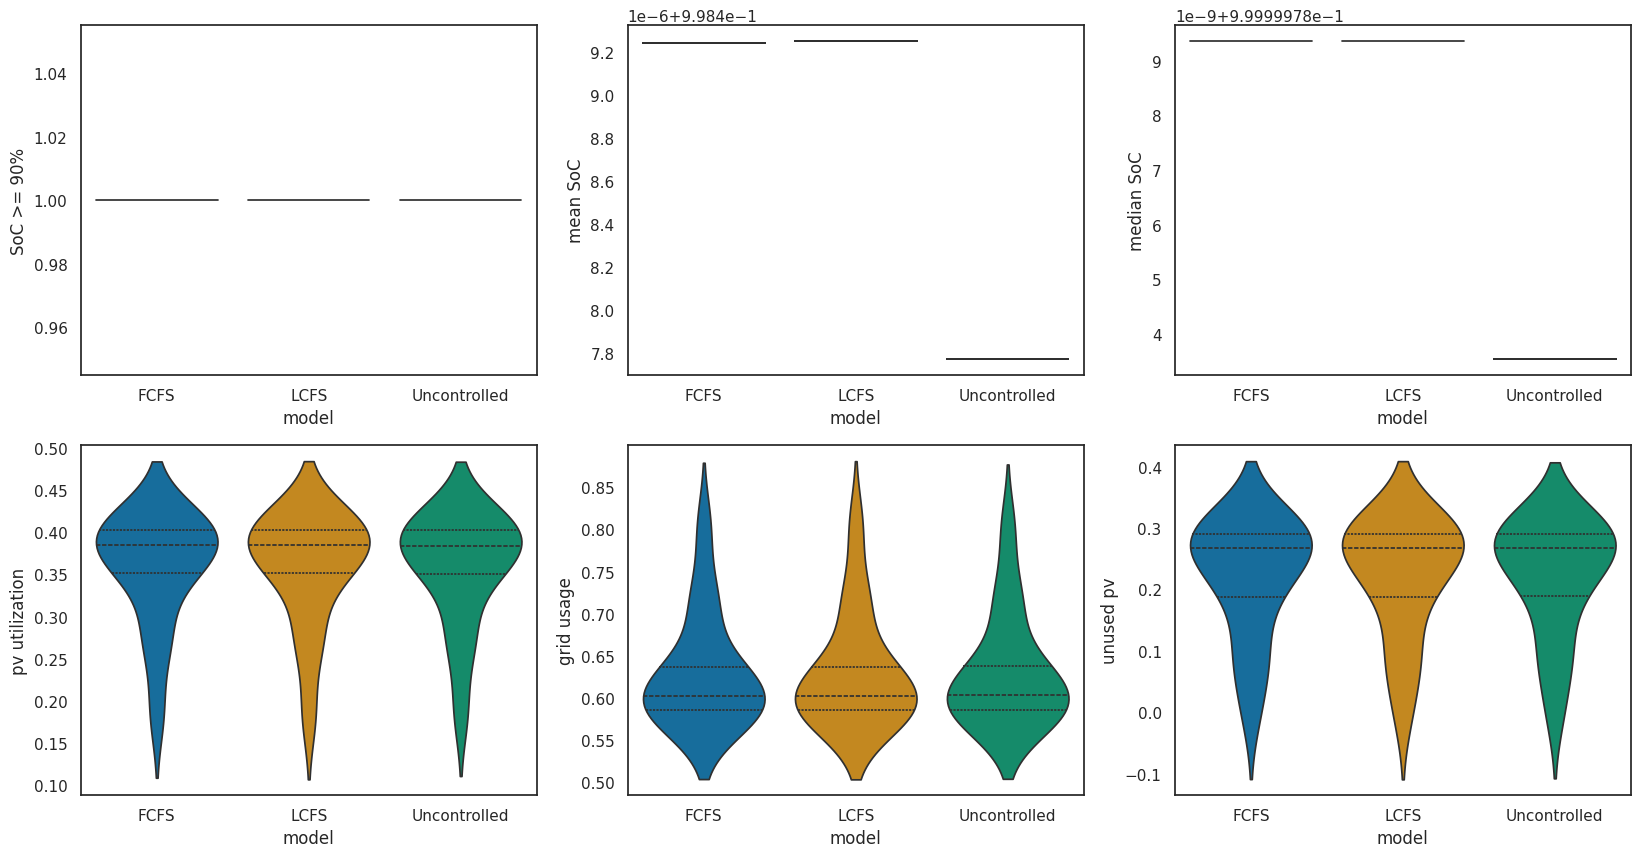

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes_flat = axes.flatten()

for i, (metric_name, statistics) in enumerate(test_statistics.items()):
    ax = axes_flat[i]
    df = pd.DataFrame.from_dict(statistics)
    # Create a violin plot using Seaborn
    sns.violinplot(data=df, inner='quartile', ax=ax)

    # plt.title('Seaborn Violin Plot Example')
    ax.set_xlabel('model')
    ax.set_ylabel(metric_name)

In [10]:
df = pd.DataFrame.from_dict(test_statistics)

for column in df.columns:
    m = np.mean(df[column].tolist(), axis=1)
    s = np.std(df[column].tolist(), axis=1)

    df[column] = [f"{m:.2g} ± {s:.2g}" for m, s in zip(m, s)]

df  # .to_latex()

,SoC >= 90%,mean SoC,median SoC,pv utilization,grid usage,unused pv
FCFS,1 ± 0,1 ± 0,1 ± 0,0.36 ± 0.064,0.63 ± 0.064,0.22 ± 0.092
LCFS,1 ± 0,1 ± 2.2e-16,1 ± 0,0.36 ± 0.064,0.63 ± 0.064,0.22 ± 0.092
Uncontrolled,1 ± 0,1 ± 2.2e-16,1 ± 2.2e-16,0.36 ± 0.063,0.63 ± 0.063,0.22 ± 0.09


In [11]:
alpha_level = 0.01  # used to compare pvalues

def highlight_alpha(styler, caption: str, alpha_level: float):
    # styler.format(lambda pvalue: f"{pvalue:.3g}")
    styler.set_caption(caption)
    styler.map(
        lambda v: "font-weight: bold" if v < alpha_level else "font-weight: normal"
    )
    return styler

In [12]:
# Perform normality test (Shapiro-Wilk test) https://docs.scipy.org/doc/scipy/tutorial/stats/hypothesis_shapiro.html#hypothesis-shapiro
# "The value of this statistic tends to be high (close to 1) for samples drawn from a normal distribution."
normality_results = defaultdict(lambda: {})
for metric_name, statistics in test_statistics.items():
    for model_name, values in statistics.items():
        shapiro_test = stats.shapiro(values)
        normality_results[metric_name][model_name] = shapiro_test.pvalue

df_normality = pd.DataFrame.from_dict(normality_results)
df_normality.style.pipe(
    lambda s: highlight_alpha(s, "p-values for Shapiro-Wilk test", alpha_level)
)

/tmp/ipykernel_1311230/2376808130.py:6: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  shapiro_test = stats.shapiro(values)


,SoC >= 90%,mean SoC,median SoC,pv utilization,grid usage,unused pv
FCFS,1.000000,1.000000,1.000000,0.001848,0.001848,0.004909
LCFS,1.000000,1.000000,1.000000,0.001788,0.001788,0.004906
Uncontrolled,1.000000,1.000000,1.000000,0.002052,0.002052,0.004861


In [13]:
print(
    df_normality.style.pipe(
        lambda s: highlight_alpha(
            s, "p-values for Shapiro-Wilk test", alpha_level)
    ).to_latex(convert_css=False)
)

\begin{table}
\caption{p-values for Shapiro-Wilk test}
\begin{tabular}{lrrrrrr}
 & SoC >= 90% & mean SoC & median SoC & pv utilization & grid usage & unused pv \\
FCFS & \font-weightnormal 1.000000 & \font-weightnormal 1.000000 & \font-weightnormal 1.000000 & \font-weightbold 0.001848 & \font-weightbold 0.001848 & \font-weightbold 0.004909 \\
LCFS & \font-weightnormal 1.000000 & \font-weightnormal 1.000000 & \font-weightnormal 1.000000 & \font-weightbold 0.001788 & \font-weightbold 0.001788 & \font-weightbold 0.004906 \\
Uncontrolled & \font-weightnormal 1.000000 & \font-weightnormal 1.000000 & \font-weightnormal 1.000000 & \font-weightbold 0.002052 & \font-weightbold 0.002052 & \font-weightbold 0.004861 \\
\end{tabular}
\end{table}



In [14]:
base_model = "FCFS"  # TODO Change to PPO!

t_test_results = defaultdict(lambda: {})

for metric_name, statistics in test_statistics.items():
    for model_name, values in statistics.items():
        if model_name == base_model:
            continue

        t_test = stats.ttest_ind(
            statistics[base_model],
            values,
        )

        t_test_results[metric_name][model_name] = t_test.pvalue

df_t_test = pd.DataFrame.from_dict(t_test_results)
df_t_test.style.pipe(
    lambda s: highlight_alpha(
        s, f"p-values for independent T-test comparing to {base_model}", alpha_level)
)

/home/guest/tsturm/acn-experiments/.conda/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


,SoC >= 90%,mean SoC,median SoC,pv utilization,grid usage,unused pv
LCFS,nan,0.000000,nan,0.997378,0.997376,0.997155
Uncontrolled,nan,0.000000,0.000000,0.994702,0.994706,0.985753


In [15]:
print(
    df_t_test.style.pipe(
        lambda s: highlight_alpha(
            s, f"p-values for independent T-test comparing to {base_model}", alpha_level)
    ).to_latex(convert_css=True)
)

\begin{table}
\caption{p-values for independent T-test comparing to FCFS}
\begin{tabular}{lrrrrrr}
 & SoC >= 90% & mean SoC & median SoC & pv utilization & grid usage & unused pv \\
LCFS & nan & \bfseries 0.000000 & nan & 0.997378 & 0.997376 & 0.997155 \\
Uncontrolled & nan & \bfseries 0.000000 & \bfseries 0.000000 & 0.994702 & 0.994706 & 0.985753 \\
\end{tabular}
\end{table}



In [16]:
# TODO Display charging behavior of the trained model